In [50]:
from datasets import load_dataset, Dataset
import numpy as np
from p_tqdm import p_map

from transformers import GPT2Tokenizer, GPT2LMHeadModel, AutoTokenizer, AutoModelForSequenceClassification
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity

from transformers import BertForSequenceClassification, Trainer, TrainingArguments
from sklearn.metrics import balanced_accuracy_score, precision_recall_fscore_support, confusion_matrix, ConfusionMatrixDisplay

import matplotlib.pyplot as plt
from torch.utils.data import DataLoader


#### Use the FIQA-PL dataset that was used in lab 1 and lab lab 2 (so we need the passages, the questions and their relations).

Got confiused with FIQA-PL, because indeed it doesn't provide relations between questions and corpus
instead used truthful_qa (small english dataset with questions with multiple possible answers)

In [51]:
ds = load_dataset("truthfulqa/truthful_qa", "generation")
ds

DatasetDict({
    validation: Dataset({
        features: ['type', 'category', 'question', 'best_answer', 'correct_answers', 'incorrect_answers', 'source'],
        num_rows: 817
    })
})

#### Create a dataset of positive and negative sentence pairs.

- In each pair the first element is a question and the second element is a passagei, i.e. "{question} {separator} {passage}", where separator should be a separator taken from the model's tokenizer.
- Use the relations to mark the positive pairs (i.e. pairs where the question is answered by the passage).
- Use your own strategy to mark negative pairs (i.e. you can draw the negative examples, but there are better strategies to define the negative examples). The number of negative examples should be larger than the number of positive examples.

In [52]:
positive_pairs, negative_pairs = [], []

In [53]:
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
model = GPT2LMHeadModel.from_pretrained('gpt2')

In [54]:
separator = tokenizer.sep_token or "[SEP]"
separator

'[SEP]'

In [55]:
def generate_pairs(question, answers):
    pairs = []
    for answer in answers:
        pairs.append(question + ' ' + separator + ' ' + answer)
    return pairs

positive_pairs = [generate_pairs(q, a) for q, a in zip(ds['validation']['question'], ds['validation']['correct_answers'])]
# positive_pairs = p_map(generate_pairs, ds['validation']['question'], ds['validation']['correct_answers']) # p_map is not working

In [56]:


#  72 mln downloads last month Sentence Transformer
model = SentenceTransformer('all-MiniLM-L6-v2')


def get_top_n_similar_answers(correct_answers, incorrect_answers, candidate_incorrect_answers, top_n=None):

    reference_vectors = model.encode(incorrect_answers)
    candidate_vectors = model.encode(candidate_incorrect_answers)
    
    combined_reference_vector = np.mean(reference_vectors, axis=0)
    
    # cosine similarities between the combined reference vector and all candidate answers
    cos_similarities = cosine_similarity([combined_reference_vector], candidate_vectors).flatten()
    
    # omit correct answers from candidates
    filtered_indices = [
        idx for idx, candidate in enumerate(candidate_incorrect_answers) 
        if candidate not in correct_answers
    ]

    
    filtered_similarities = cos_similarities[filtered_indices]
    sorted_indices = np.argsort(filtered_similarities)[::-1][:top_n]
    
    top_n_candidates = [candidate_incorrect_answers[filtered_indices[idx]] for idx in sorted_indices]

    return top_n_candidates



def generate_incorrect_answers(index):
    correct_answers = ds['validation']['correct_answers']
    incorrect_answers = ds['validation']['incorrect_answers']
    candidate_incorrect_answers = [
        incorrect for idx, incorrect in enumerate(incorrect_answers) if idx != index
    ]
    top_n = 3
    # flaten the list of candidate incorrect answers
    candidate_incorrect_answers = [item for sublist in candidate_incorrect_answers for item in sublist]
    # Get top N most similar incorrect answers
    similar_incorrect_answers = get_top_n_similar_answers(
        correct_answers[index],
        incorrect_answers[index],
        candidate_incorrect_answers,
        top_n
    )
    return similar_incorrect_answers + incorrect_answers[index]


ds_len = len(ds['validation']['correct_answers'])

# new_incorrect_answers = p_map(
#     generate_incorrect_answers,
#     range(ds_len)
# )

# p_map stopped working

new_incorrect_answers = [
    generate_incorrect_answers(i) for i in range(ds_len)
]

In [57]:
negative_pairs = [generate_pairs(q, a) for q, a in zip(ds['validation']['question'], new_incorrect_answers)]

In [58]:
flatten_negative_pairs = [item for sublist in negative_pairs for item in sublist]
flatten_positive_pairs = [item for sublist in positive_pairs for item in sublist]

In [59]:
print(f'positive answers {len(flatten_positive_pairs)} and negative answers {len(flatten_negative_pairs)}')

positive answers 2600 and negative answers 5769


Added three incorrect answers to each questions derived from the incorrect answers of other questions, utilizing cosine similarity to ensure relevance

#### The dataset from point 2 should be split into training, evaluation and testing subsets.

In [60]:
all_pairs = flatten_positive_pairs + flatten_negative_pairs

# labels: 1 for positive pairs, 0 for negative pairs
labels = [1] * len(flatten_positive_pairs) + [0] * len(flatten_negative_pairs)

# Shuffle
indices = np.random.permutation(len(all_pairs))
all_pairs = [all_pairs[i] for i in indices]
labels = [labels[i] for i in indices]

#  split 70% train, 15% eval, 15% test
total_size = len(all_pairs)
train_size = int(0.7 * total_size)
eval_size = int(0.15 * total_size)
test_size = total_size - train_size - eval_size

# Dataset: text, label
data = {'text': all_pairs, 'label': labels}
dataset = Dataset.from_dict(data)

train_dataset = dataset.select(range(train_size))
eval_dataset = dataset.select(range(train_size, train_size + eval_size))
test_dataset = dataset.select(range(train_size + eval_size, total_size))


#### Train a text classifier using the Transformers library
distinguishes between the positive and the negative pairs. To make the process manageable use models of size base and a runtime providing GPU/TPU acceleration. Consult the discussions related to fine-tuning Transformer models to select sensible set of parameters. You can also run several trainings with different hyper-parameters, if you have access to large computing resources.

In [61]:
# model with 60 mln downloads last month
model_name = "bert-base-uncased"  
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [62]:
def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=128)

# Apply the tokenizer to the datasets
train_tokenized = train_dataset.map(tokenize_function, batched=True)
eval_tokenized = eval_dataset.map(tokenize_function, batched=True)
test_tokenized = test_dataset.map(tokenize_function, batched=True)


Map: 100%|██████████| 1256/1256 [00:00<00:00, 21451.71 examples/s]


In [63]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = np.argmax(pred.predictions, axis=1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average="binary")
    balanced_accuracy = balanced_accuracy_score(labels, preds)
    return {
        "balanced_accuracy": balanced_accuracy,
        "f1": f1,
        "precision": precision,
        "recall": recall
    }


In [64]:
train_dataloader = DataLoader(train_tokenized, batch_size=16, shuffle=True)
eval_dataloader = DataLoader(eval_tokenized, batch_size=16)
test_dataloader = DataLoader(test_tokenized, batch_size=16)

In [65]:

# 60 mln downloads last month model
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

# Define training arguments
training_args = TrainingArguments(
    output_dir='./results',
    evaluation_strategy='epoch',
    save_strategy='epoch',
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    metric_for_best_model='balanced_accuracy',
    load_best_model_at_end=True,
    greater_is_better=True,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_tokenized,
    eval_dataset=eval_tokenized,
    compute_metrics=compute_metrics

)

trainer.train()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/Users/bochnak/anaconda3/envs/nlp/lib/python3.11/site-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
 33%|███▎      | 367/1101 [02:47<04:43,  2.59it/s]

{'eval_loss': 0.36286601424217224, 'eval_balanced_accuracy': 0.8037814018520217, 'eval_f1': 0.7450462351387054, 'eval_precision': 0.8269794721407625, 'eval_recall': 0.6778846153846154, 'eval_runtime': 9.7448, 'eval_samples_per_second': 128.787, 'eval_steps_per_second': 8.107, 'epoch': 1.0}


 45%|████▌     | 500/1101 [03:51<04:25,  2.27it/s]

{'loss': 0.438, 'grad_norm': 7.094197750091553, 'learning_rate': 1.0917347865576748e-05, 'epoch': 1.36}


 67%|██████▋   | 734/1101 [05:45<02:15,  2.71it/s]

{'eval_loss': 0.3241387605667114, 'eval_balanced_accuracy': 0.8368593563766389, 'eval_f1': 0.7878787878787878, 'eval_precision': 0.8297872340425532, 'eval_recall': 0.75, 'eval_runtime': 9.9308, 'eval_samples_per_second': 126.375, 'eval_steps_per_second': 7.955, 'epoch': 2.0}


 91%|█████████ | 1000/1101 [07:42<00:41,  2.40it/s]

{'loss': 0.2235, 'grad_norm': 1.9304497241973877, 'learning_rate': 1.8346957311534968e-06, 'epoch': 2.72}


100%|██████████| 1101/1101 [08:35<00:00,  3.02it/s]

{'eval_loss': 0.338667094707489, 'eval_balanced_accuracy': 0.8470506326212524, 'eval_f1': 0.8020176544766708, 'eval_precision': 0.843501326259947, 'eval_recall': 0.7644230769230769, 'eval_runtime': 9.4084, 'eval_samples_per_second': 133.392, 'eval_steps_per_second': 8.397, 'epoch': 3.0}


100%|██████████| 1101/1101 [08:37<00:00,  2.13it/s]

{'train_runtime': 517.7624, 'train_samples_per_second': 33.942, 'train_steps_per_second': 2.126, 'train_loss': 0.31654600962847607, 'epoch': 3.0}


TrainOutput(global_step=1101, training_loss=0.31654600962847607, metrics={'train_runtime': 517.7624, 'train_samples_per_second': 33.942, 'train_steps_per_second': 2.126, 'total_flos': 1155978421724160.0, 'train_loss': 0.31654600962847607, 'epoch': 3.0})

#### Report the results you have obtained for the model. Use appropriate measures, since the dataset is not balanced.

100%|██████████| 79/79 [00:09<00:00,  8.61it/s]


Test Results: {'eval_loss': 0.29952314496040344, 'eval_balanced_accuracy': 0.86421603223924, 'eval_f1': 0.811554332874828, 'eval_precision': 0.8240223463687151, 'eval_recall': 0.7994579945799458, 'eval_runtime': 9.3531, 'eval_samples_per_second': 134.287, 'eval_steps_per_second': 8.446, 'epoch': 3.0}


100%|██████████| 79/79 [00:09<00:00,  8.62it/s]


Test Metrics:
Balanced Accuracy: 0.8642
F1 Score: 0.8116
Precision: 0.8240
Recall: 0.7995


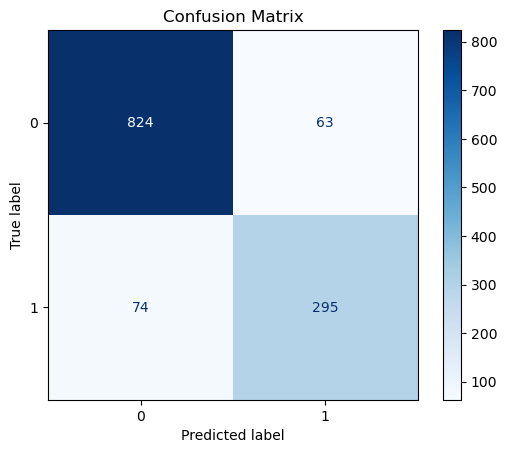

In [66]:
test_results = trainer.evaluate(test_tokenized)

print("Test Results:", test_results)

test_predictions = trainer.predict(test_tokenized)

test_metrics = compute_metrics(test_predictions)

print("Test Metrics:")
print(f"Balanced Accuracy: {test_metrics['balanced_accuracy']:.4f}")
print(f"F1 Score: {test_metrics['f1']:.4f}")
print(f"Precision: {test_metrics['precision']:.4f}")
print(f"Recall: {test_metrics['recall']:.4f}")

true_labels = test_predictions.label_ids
predicted_labels = np.argmax(test_predictions.predictions, axis=1)

cm = confusion_matrix(true_labels, predicted_labels)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()


Trained Model score for balanced accuracy is 0.87 which is quite good result, especially for not the easiest dataset with more than twice as many wrong answers (2600 positive labels vs 5679 negative labels)

#### Use the classifier as a re-ranker for finding the answers to the questions.
Since the re-ranker is slow, you have to limit the subset of possible passages to top-n (10, 50 or 100 - depending on your GPU) texts returned by much faster model, e.g. FTS.

In [67]:
# TODO

#### Compute how much the result of searching the passages improved over the results from lab 2. Use NDCG to compare the results.

Used different model so gonna just calculate NDCG of this model

In [68]:
def dcg_at_k(scores, k):
    scores = scores[:k]
    return sum(score / np.log2(idx + 2) for idx, score in enumerate(scores))

# nDCG@k
def ndcg_at_k(relevance_scores, k=10):
    ideal_scores = sorted(relevance_scores, reverse=True)
    dcg = dcg_at_k(relevance_scores, k)
    idcg = dcg_at_k(ideal_scores, k)
    return dcg / idcg if idcg > 0 else 0

# TODO

#### Question 1: Do you think simpler methods, like Bayesian bag-of-words model, would work for sentence-pair classification? Justify your answer.

Simpler methods like a Bayesian bag-of-words model can be effective, they often fail to capture the contextual relationships. In my approach, I used cosine similarity with the Sentence Transformer model (`all-MiniLM-L6-v2`), which encodes sentences into dense vectors, allowing for effective semantic comparison. This model's popularity (72 million downloads last month) highlights its effectiveness in understanding context, making it superior for this task.

---

#### Question 2: What hyper-parameters did you select for training? What resources did you consult?

I selected the following hyper-parameters for training:
- Learning Rate: 2e-5
- Batch Size: 16
- Number of Epochs: 3
- Weight Decay: 0.01
- Evaluation Strategy: Evaluate at the end of each epoch
- Load best model at the end

These were chosen based on insights from Hugging Face documentation.

---

#### Question 3: What are the pros and cons of neural network models in NLP?

**Pros:**
1. Contextual Understanding: Neural networks capture contextual relationships, improving performance in tasks like sentence-pair classification.
2. Transfer Learning: Pre-trained models can be fine-tuned on specific tasks, leveraging knowledge from large datasets.

**Cons:**
1. Resource Intensive: Large models require significant computational resources, which can be a barrier for smaller projects.
2. Overfitting Risk: The complexity of neural networks can lead to overfitting, necessitating careful regularization and validation.
